# Loan Default Predictor using Home Equity Data

Data downloaded from [github](https://github.com/Owerre/home-equity-loan/blob/master/data/hmeq.csv)

Columns:
* BAD: 1 = applicant defaulted on loan or seriously delinquent; 0 = applicant paid loan
* LOAN: Amount of the loan request
* MORTDUE: Amount due on existing mortgage
* VALUE: Value of current property
* REASON: DebtCon = debt consolidation; HomeImp = home improvement
* JOB: Occupational categories
* YOJ: Years at present job
* DEROG: Number of major derogatory reports
* DELINQ: Number of delinquent credit lines
* CLAGE: Age of oldest credit line in months
* NINQ: Number of recent credit inquiries
* CLNO: Number of credit lines
* DEBTINC: Debt-to-income ratio

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

In [2]:
df = pd.read_csv("hmeq.csv")
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


# Exploratory Data Analysis

Text(0.5, 1.0, 'HMEQ Financial Correlation Heatmap')

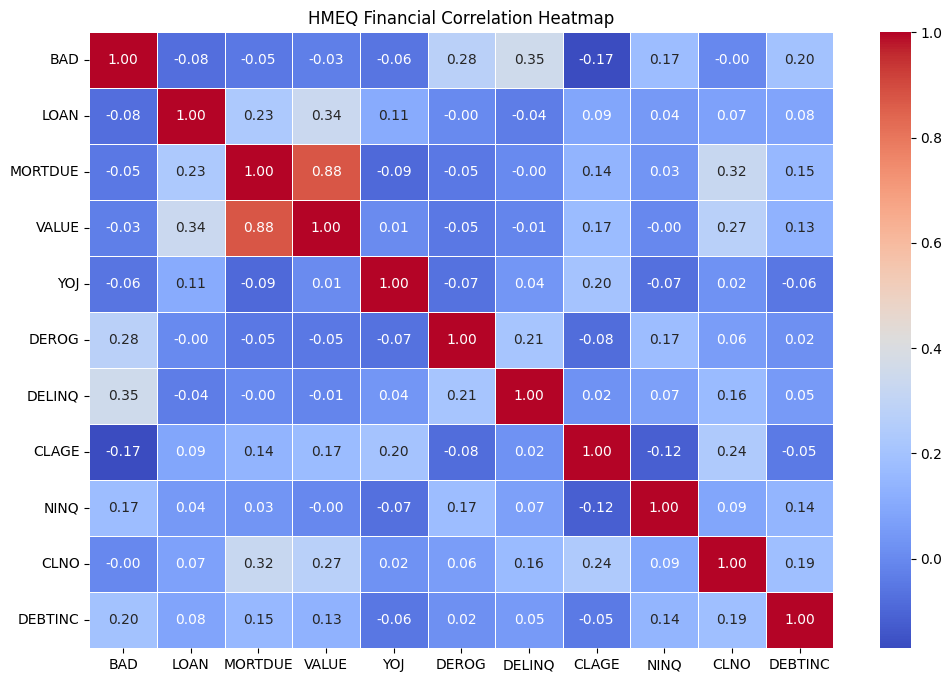

In [3]:
# Risk Matrix Correlation Heatmap
# By looking at the BAD column we can see which variables affect it most
plt.figure(figsize=(12, 8))
corr = df.select_dtypes(include=[np.number]).corr()  # filter for numeric columns only for correlation
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('HMEQ Financial Correlation Heatmap')

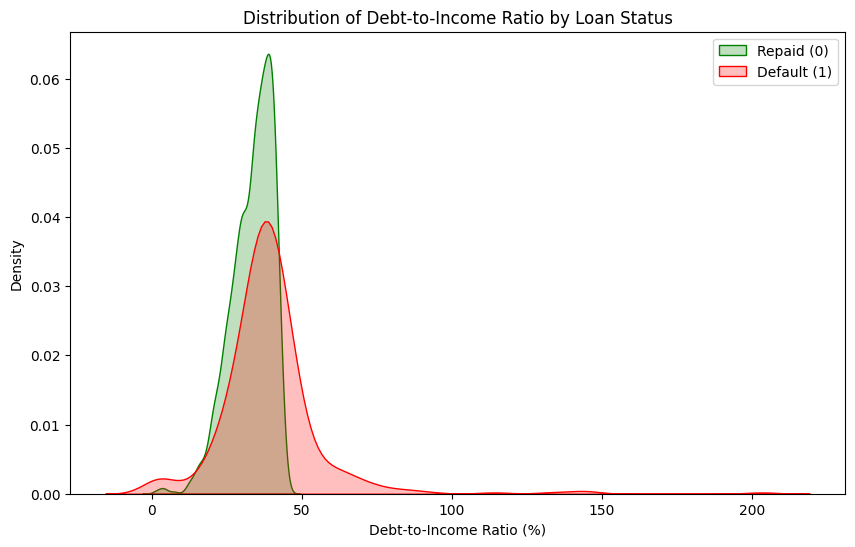

In [4]:
# Let's focus on DEBTINC which is a strong predictor of default
# We use the Kernel Density Estimate to see how the distributions of debt differ
# between those who defaulted from those who didn't
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df[df['BAD'] == 0], x='DEBTINC', fill=True, label='Repaid (0)', color='green')
sns.kdeplot(data=df[df['BAD'] == 1], x='DEBTINC', fill=True, label='Default (1)', color='red')
plt.title('Distribution of Debt-to-Income Ratio by Loan Status')
plt.xlabel('Debt-to-Income Ratio (%)')
plt.legend()

Observations:
* Successful borrowers are clustered heavily between a 25% and 40%.
* The red curve has a much longer "tail" extending beyond 100% or 200%.
* Above the 45-50% mark, the green area almost vanishes, while the red area continues.
* Being above 45% is a "red flag" for lenders.
* Both curves peak around the same area (roughly 35-40%). DEBTINC alone isn't a perfect predictor.
* Other features should be included like DELINQ or DEROG.
* The negative values indicate data entry errors or specific accounting offsets.

# Prepare Data and Create Model

In [5]:
# data cleaning
# fill numeric with median, categorical with mode
for col in df.select_dtypes(exclude=['object']).columns:
    df[col] = df[col].fillna(df[col].median())
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna(df[col].mode()[0])

# encode categories
df = pd.get_dummies(df, drop_first=True)

In [6]:
X = df.drop('BAD', axis=1)
y = df['BAD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [7]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10, 
    random_state=42,
    class_weight='balanced' 
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

# Model Evaluation

In [8]:
# evaluation
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

ROC-AUC Score: 0.9378

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       954
           1       0.74      0.71      0.72       238

    accuracy                           0.89      1192
   macro avg       0.83      0.83      0.83      1192
weighted avg       0.89      0.89      0.89      1192



Text(0.5, 1.0, 'Confusion Matrix - Home Equity Loan Default Predictor')

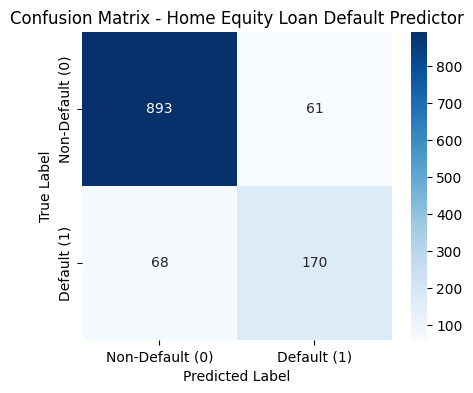

In [9]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Default (0)', 'Default (1)'], 
            yticklabels=['Non-Default (0)', 'Default (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Home Equity Loan Default Predictor')

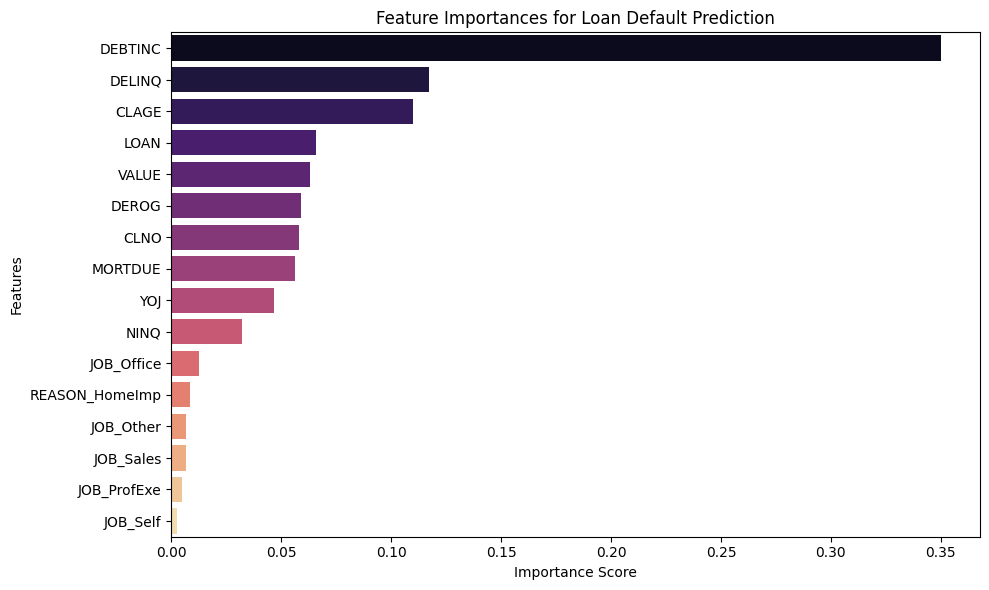

In [10]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, hue='Feature', legend=False, palette='magma')
plt.title('Feature Importances for Loan Default Prediction')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
# plt.savefig('feature_importance.png')